# 課題："House Prices:Advanced Regression Techniques"   from Kaggle

## ＜概要＞
### ・Goal
    アイオワ州エイムズ地区の過去の住宅販売実績データから、各住宅価格を予測する。
### ・使用データ
    住宅の特徴を表す79個の変数からなる、1,460戸のデータ。
    予測するテストデータは1,459戸分。
### ・評価基準
    予測の精度は、予測価格と実際の価格それぞれの対数のRMSEで測る。

In [1]:
#必要なライブラリをインポート

% matplotlib inline

from __future__ import print_function

import copy

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error
from datetime import datetime

## ＜データの前処理＞

In [2]:
data = pd.read_csv("Kaggle/train.csv")
test_data_org = pd.read_csv("Kaggle/test.csv")
train_data_org = data

In [3]:
print("教師データ行数:",data.shape[0])
print("教師データカラム数:",data.shape[1])
print("テストデータ行数:",test_data_org.shape[0])
print("テストデータカラム数:",test_data_org.shape[1])

教師データ行数: 1460
教師データカラム数: 81
テストデータ行数: 1459
テストデータカラム数: 80


### カテゴリーデータの変換、欠損値の対処
#### ・カテゴリーデータはダミー変数に変換する。
#### ・NULLとinfは0に置換

In [4]:
#テストデータを含めて加工する（カラムを先に揃える）

##trainとtestを1つのDataFrameに結合し、それぞれのフラグを立てておく
train_data_org['label'] = 0
test_data_org['label'] = 1
concat_data = pd.concat([train_data_org , test_data_org])

##カテゴリカル変数をダミー変数に変換
data_dummies = pd.get_dummies(concat_data,dummy_na=True)

##NULLとinfを0に置換
data_dummies_2 = data_dummies.replace([np.nan,np.inf], 0)

In [5]:
data_dummies.head()

,1stFlrSF,2ndFlrSF,3SsnPorch,BedroomAbvGr,BsmtFinSF1,BsmtFinSF2,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,EnclosedPorch,...,SaleType_New,SaleType_Oth,SaleType_WD,SaleType_nan,Street_Grvl,Street_Pave,Street_nan,Utilities_AllPub,Utilities_NoSeWa,Utilities_nan
0,856,854,0,3,706.0,0.0,1.0,0.0,150.0,0,...,0,0,1,0,0,1,0,1,0,0
1,1262,0,0,3,978.0,0.0,0.0,1.0,284.0,0,...,0,0,1,0,0,1,0,1,0,0
2,920,866,0,3,486.0,0.0,1.0,0.0,434.0,0,...,0,0,1,0,0,1,0,1,0,0
3,961,756,0,3,216.0,0.0,1.0,0.0,540.0,272,...,0,0,1,0,0,1,0,1,0,0
4,1145,1053,0,4,655.0,0.0,1.0,0.0,490.0,0,...,0,0,1,0,0,1,0,1,0,0


In [6]:
print("加工後")
print("全データ行数:",data_dummies_2.shape[0])
print("全データカラム数:",data_dummies_2.shape[1])

加工後
全データ行数: 2919
全データカラム数: 334


### 使用カラムの整理

In [7]:
##train_data加工
##使用列整理
target_col = 'SalePrice' #目的変数
exclude_cols = ['Id','SalePrice','label'] 
feature_cols = [col for col in data_dummies_2.columns if col not in exclude_cols]

In [8]:
len(feature_cols)

331

### 特徴量の作成
#### 相関係数が高い係数は割り算して特徴量を作成する

In [9]:
#相関係数が高いもの同士を割り算し、新たな特徴量を作成
cutoff_r = 0.9 #相関係数の閾値(絶対値)
new_added_col = []
for i in range(0, len(feature_cols)-1):
    for j in range(i+1, len(feature_cols)):
        first_col_name = feature_cols[i]
        second_col_name = feature_cols[j]
        r = spearmanr(data_dummies_2[first_col_name], data_dummies_2[second_col_name]).correlation
        if abs(r) > cutoff_r:
            new_colname = first_col_name + "_div_" + second_col_name
            data_dummies_2[new_colname] = data_dummies_2[first_col_name] / (data_dummies_2[second_col_name] + 0.01)
            new_added_col.append(new_colname)
            
feature_cols = feature_cols + new_added_col

/Users/yasukoshimokado/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/yasukoshimokado/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/yasukoshimokado/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/yasukoshimokado/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/yasukoshimokado/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [10]:
print("新たに作成したカラム数:",len(new_added_col))

新たに作成したカラム数: 31


In [11]:
#trainとtestデータを改めて分ける
train_data = data_dummies_2[data_dummies_2['label'] == 0]
test_data = data_dummies_2[data_dummies_2['label'] == 1]

#不要な列を削除
train_data = train_data.drop('label',axis=1)
test_data = test_data.drop('label',axis=1)
test_data_2 = test_data.drop(['Id','SalePrice'],axis=1)

### 教師データを、train:test=7:3に分割してモデル作成する

In [12]:
y = np.array(train_data[target_col])
X = np.array(train_data[feature_cols])

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=1234)

## ＜モデルの作成＞
### 勾配ブースティングを利用する

In [13]:
###GradientBoosting使用
from sklearn.ensemble import GradientBoostingRegressor

gb = GradientBoostingRegressor(n_estimators=3000,learning_rate=0.01)

gb.fit(X_train, y_train)

ypred = gb.predict(X_test)

#RMSEを計算
print("RMSE:", np.sqrt(mean_squared_error(y_true=np.log(y_test), y_pred=np.log(ypred))))

RMSE: 0.124637141046


## テストデータで予測

In [14]:
###テストデータに適用###
ypred_2 = gb.predict(test_data_2)

result = pd.DataFrame([[test_data.loc[0,'Id'],ypred_2[0]]],columns=list('AB'))

for i in range(len(ypred_2)):
    new = pd.DataFrame([[test_data.loc[i+1,'Id'],ypred_2[i+1]]],columns=list('AB'))
    result = result.append(new,ignore_index=True)
    if i == 1457:
        break

result.rename(columns={'A':'Id','B':'SalePrice'},inplace=True)

In [15]:
result.head()

,Id,SalePrice
0,1461,126917.975590
1,1462,164839.933597
2,1463,182949.090247
3,1464,186980.046306
4,1465,194543.517869


### 精度チェック
#### 特徴量の重要度を確認し、一定値に満たない場合は該当カラムは外す

In [16]:
##特徴量の重要度確認

def varImpPlot(clf, feature_names, topN = 10, verbose = True):
    feature_names = np.array(feature_names)
    feature_importance = clf.feature_importances_
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    
    topN_feature = feature_importance[sorted_idx][len(feature_importance) - topN:]
    topN_feature_name = feature_names[sorted_idx][len(feature_importance) - topN:]
    pos = np.arange(topN) + .5
    plt.barh(pos, topN_feature, align='center')
    plt.yticks(pos, topN_feature_name)
    plt.xlabel('Relative Importance')
    plt.title('Variable Importance')
    plt.show()
    
    rev_sorted_idx = np.argsort(feature_importance)[::-1]
    if verbose:
        for i, v in zip(feature_names[rev_sorted_idx], feature_importance[rev_sorted_idx]):
            print(i, v)

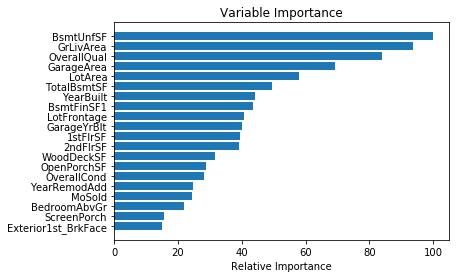

In [17]:
varImpPlot(gb, feature_cols, topN=20, verbose=False)

In [18]:
#重要度0のものを削除
feature_importance = gb.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
feature_cols_ar = np.array(feature_cols)
new_feature_cols = feature_cols_ar[feature_importance > 0]

In [19]:
print("使用カラム数:",new_feature_cols.shape[0])

使用カラム数: 274


### 再度、教師データをtrain:test=7:3に分割してモデル作成する

In [20]:
y = np.array(train_data[target_col])
X = np.array(train_data[new_feature_cols])

X_train, X_test, y_train, y_test = \
 train_test_split(X, y, test_size=0.3, random_state=1234)

In [21]:
gb = GradientBoostingRegressor(n_estimators=3000,learning_rate=0.01)

gb.fit(X_train, y_train)

ypred = gb.predict(X_test)

print("Root Means Square:", np.sqrt(mean_squared_error(y_true=np.log(y_test), y_pred=np.log(ypred))))

Root Means Square: 0.124529133137


## ＜テストデータで予測＞
#### 重要度0のカラムを削除したモデルを使用する。

In [22]:
###テストデータに適用###
test_data_3 = np.array(test_data_2[new_feature_cols])
ypred_2 = gb.predict(test_data_3)
#ypred_2 = gb.predict(test_data_2)

result = pd.DataFrame([[test_data.loc[0,'Id'],ypred_2[0]]],columns=list('AB'))

for i in range(len(ypred_2)):
    new = pd.DataFrame([[test_data.loc[i+1,'Id'],ypred_2[i+1]]],columns=list('AB'))
    result = result.append(new,ignore_index=True)
    if i == 1457:
        break

result.rename(columns={'A':'Id','B':'SalePrice'},inplace=True)

In [23]:
result.head()

,Id,SalePrice
0,1461,126697.626571
1,1462,164839.933597
2,1463,182949.090247
3,1464,186980.046306
4,1465,193119.596990


In [30]:
#csvに書き込み
result.to_csv('result_HousePrices.csv',index=None)